In [1]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.python.framework import ops
L = tf.layers

In [3]:
import matplotlib.pyplot as plt
% matplotlib inline

In [4]:
data_dir = os.path.expanduser('/home/paperspace/Insight/video-representations/data/downsampled')
filenames = os.listdir(data_dir)

def load_data(filename):
    with np.load(os.path.join(data_dir, filename)) as f:
        frames = [arr for name, arr, in f.items()]
    
    return list(frames[0])

def pad_frames(frames, final_length=20):
    pad = np.zeros((3, 60, 80), dtype=np.int8)[np.newaxis, :, :, :]
    if frames.shape[0] <=20 :
        padstack = np.repeat(pad, final_length - frames.shape[0], axis=0)
        return np.concatenate((padstack, frames))
    else:
        return frames

def load_all(everyn=1):
    frames = [load_data(filename) for filename in filenames[::everyn]]
    X = np.concatenate([np.concatenate([f[:-1] for f in frame]) for frame in frames]) / 255
    y = np.concatenate([np.concatenate([f[1:] for f in frame]) for frame in frames]) / 255
    return X, y

In [5]:
X, y = load_all(everyn=32)

In [6]:
print(X.shape, X.nbytes / 1000000)

(5035, 3, 60, 80) 290.016


In [7]:
# below loads x, y for a single file
# frames = np.concatenate([pad_frames(frame) for frame in frames])
# X = np.concatenate([f[:-1] for f in frames]) / 255
# y = np.concatenate([f[1:] for f in frames]) / 255
# print(X.shape, y.shape)

In [11]:
def selu(x):
    with ops.name_scope('elu'):
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
    return scale * tf.where(x >= 0.0, x, alpha * tf.nn.elu(x))

def dense_reshape(incoming, units, **kwargs):
    shape = incoming.get_shape().as_list()
    newdim = np.prod(shape[1:])
    reshaped = tf.reshape(incoming, (-1, newdim))
    return L.dense(reshaped, units=units, **kwargs)

def encoder(image):
    input_layer = tf.reshape(image, (-1, 60, 80, 3))
    
    conv1 = L.conv2d(
        input_layer, filters=32, kernel_size=3, activation=selu
    )
    
#     conv2 = L.conv2d(
#         conv1, filters=16, kernel_size=3, activation=selu
#     )
    
    conv3 = L.conv2d(
        conv1, filters=64, kernel_size=5, activation=selu
    )
    
    shape = conv3.get_shape().as_list()
    print(shape)
    newdim = shape[1] * shape[2] * shape[3]
    print(newdim)
    conv3_flat = tf.reshape(conv3, (-1, newdim))
    print(conv3_flat.shape)
    
    dense1 = dense_reshape(conv3, units=512, activation=selu)
    
    return dense1

def transitions(encoded):
    outputs = None
    return outputs

def decoder(encoded):
    dense1 = L.dense(encoded, units=255744, activation=selu)
    dense1_reshaped = tf.reshape(dense1, (-1, 54, 74, 64))
    
    deconv1 = L.conv2d_transpose(
        dense1_reshaped, filters=32, kernel_size=5, activation=selu
    )
    
    
#     deconv2 = L.conv2d_transpose(
#         deconv1, filters=8, kernel_size=3, activation=selu
#     )
    
    deconv3 = L.conv2d_transpose(
        deconv1, filters=3, kernel_size=3, activation=tf.nn.relu
    )
    
    deconv3_reshaped = tf.transpose(deconv3, perm=(0, 3, 1, 2))
    
    return deconv3_reshaped

In [12]:
def iterate_minibatches(inputs, targets, batchsize=32, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        idxs = np.arange(len(inputs))
        np.random.shuffle(idxs)

    for idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = idxs[idx:idx + batchsize]
        else:
            excerpt = slice(idx, idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [13]:
epochs = 3
input_var = tf.placeholder(dtype=tf.float32, shape=(None, 3, 60, 80), name='input')
target_var = tf.placeholder(dtype=tf.float32, shape=(None, 3, 60, 80), name='target')

encoded = encoder(input_var)
decoded = decoder(encoded)

loss = tf.reduce_mean(tf.pow(decoded - target_var, 2))
train_step = tf.train.AdamOptimizer().minimize(loss)

[None, 54, 74, 64]
255744
(?, 255744)


In [14]:
config = tf.ConfigProto(log_device_placement=True)

with tf.Session(config=config) as sesh:
    
    init = tf.global_variables_initializer()
    sesh.run(init)
    
    current_loss = loss.eval({input_var: X, target_var: y})
    print('Initial loss: {}'.format(current_loss))
    
    for epoch in range(epochs):
        batch_no = 0
        for batch in iterate_minibatches(X, y, batchsize=128, shuffle=True):
            X_, y_ = batch
            train_step.run({input_var: X_, target_var: y_})
        
            current_loss = loss.eval({input_var: X, target_var: y})
            print('Epoch {} batch {} loss: {}'.format(epoch, batch_no, current_loss))
            batch_no += 1
        
    output = sesh.run(decoded, {input_var: X})

ResourceExhaustedError: OOM when allocating tensor with shape[5035,58,78,32]
	 [[Node: conv2d_3/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](Reshape_4, conv2d_2/kernel/read)]]
	 [[Node: Mean_1/_9 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_220_Mean_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'conv2d_3/convolution', defined at:
  File "/usr/lib/python3.4/runpy.py", line 170, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.4/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.4/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.4/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.4/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.4/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.4/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.4/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.4/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.4/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.4/dist-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.4/dist-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.4/dist-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-67df5a39b5fb>", line 5, in <module>
    encoded = encoder(input_var)
  File "<ipython-input-11-0ae02dab03a4>", line 17, in encoder
    input_layer, filters=32, kernel_size=3, activation=selu
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/layers/convolutional.py", line 551, in conv2d
    return layer.apply(inputs)
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/layers/base.py", line 492, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/layers/base.py", line 441, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/layers/convolutional.py", line 158, in call
    data_format=utils.convert_data_format(self.data_format, self.rank + 2))
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/ops/nn_ops.py", line 670, in convolution
    op=op)
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/ops/nn_ops.py", line 338, in with_space_to_batch
    return op(input, num_spatial_dims, padding)
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/ops/nn_ops.py", line 662, in op
    name=name)
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/ops/nn_ops.py", line 131, in _non_atrous_convolution
    name=name)
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/ops/gen_nn_ops.py", line 399, in conv2d
    data_format=data_format, name=name)
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[5035,58,78,32]
	 [[Node: conv2d_3/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](Reshape_4, conv2d_2/kernel/read)]]
	 [[Node: Mean_1/_9 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_220_Mean_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [86]:
new_frames = output.transpose((0, 2, 3, 1))
# new_frames = (new_frames + output.min()) / output.max()

In [87]:
new_frames[9].shape

(60, 80, 3)

In [88]:
new_frames[9]

array([[[ 0.34638026,  0.40444931,  0.41534728],
        [ 0.22073686,  0.51584476,  0.42518407],
        [ 0.28121296,  0.36267817,  0.265921  ],
        ..., 
        [ 0.43492481,  0.16665162,  0.26603454],
        [ 0.42788813,  0.38585192,  0.36863488],
        [ 0.50297022,  0.3500194 ,  0.48797065]],

       [[ 0.2162807 ,  0.40598765,  0.27616066],
        [ 0.10395826,  0.60837507,  0.28401172],
        [ 0.18749489,  0.32796842,  0.32868403],
        ..., 
        [ 0.25261286,  0.44263023,  0.40509546],
        [ 0.2264701 ,  0.20609167,  0.547216  ],
        [ 0.39762923,  0.34456548,  0.35900652]],

       [[ 0.30762726,  0.35469976,  0.21565779],
        [ 0.55201572,  0.50100654,  0.46595737],
        [ 0.27263844,  0.67866594,  0.19570956],
        ..., 
        [ 0.40869433,  0.32320684,  0.15551139],
        [ 0.41180876,  0.44378218,  0.3042621 ],
        [ 0.44700307,  0.1893881 ,  0.29320195]],

       ..., 
       [[ 0.31274527,  0.25210848,  0.39933392],
        

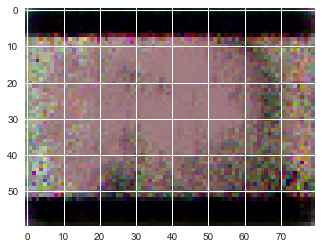

In [96]:
plt.imshow(new_frames[120])

In [32]:
output[10] == output[11]

array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ..., 
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ..., 
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ..., 
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ..., 
       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ..., 
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ..., 
        [False, False, False],
        [False, False, False],
        [F